In [45]:
# Khai báo thư viện
import pandas as pd
import numpy as np
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



In [17]:
encodings_to_try = ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv('Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', sep=';', encoding=encoding)
        print("File successfully read with encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Failed to read file with encoding:", encoding)

# Lưu DataFrame vào file CSV mới
df.to_csv('new.csv', index=False)

print("Đã lưu thành công vào new.csv")

df = pd.read_csv('new.csv')
df.head()

Failed to read file with encoding: utf-8
File successfully read with encoding: latin1
Đã lưu thành công vào new.csv


,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [18]:
df = pd.concat([df['Ngày'], df['13']], axis = 1)
df.head()

,Ngày,13
0,01/01/2021,964.4
1,01/02/2021,1019.7
2,01/03/2021,988.4
3,01/04/2021,1010.8
4,01/05/2021,1061.5


In [19]:
feats = ['13']

In [20]:
from sklearn.preprocessing import PowerTransformer

X = df['13'].values.reshape(-1, 1)

# Áp dụng PowerTransformer
transformer = PowerTransformer()
X_transformed = transformer.fit_transform(X)

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\

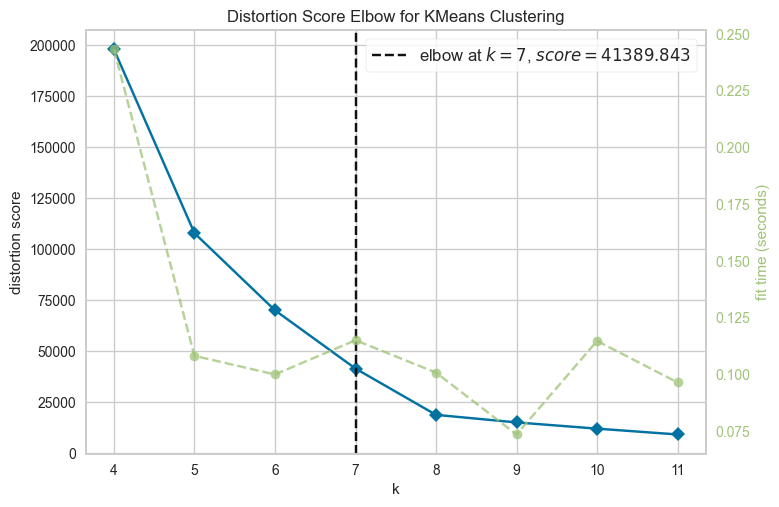

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [46]:
from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(4,12))
Elbow_M.fit(X)
Elbow_M.show()

In [21]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)

#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds


In [24]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [28]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 0.000289946
[200]	valid_0's multi_logloss: 0.000294104
[200]	valid_0's multi_logloss: 0.000268152
[200]	valid_0's multi_logloss: 0.0127261
[200]	valid_0's multi_logloss: 0.000163985
[400]	valid_0's multi_logloss: 0.000162847
[600]	valid_0's multi_logloss: 0.000162551
[800]	valid_0's multi_logloss: 0.000162414
[1000]	valid_0's multi_logloss: 0.000162337
[1200]	valid_0's multi_logloss: 0.000162287
[1400]	valid_0's multi_logloss: 0.000162252
[1600]	valid_0's multi_logloss: 0.000162227
[1800]	valid_0's multi_logloss: 0.000162208
[2000]	valid_0's multi_logloss: 0.000162193
[2200]	valid_0's multi_logloss: 0.00016218
[2400]	valid_0's multi_logloss: 0.00016217
[2600]	valid_0's multi_logloss: 0.000162162
[2800]	valid_0's multi_logloss: 0.000162154
[3000]	valid_0's multi_logloss: 0.000162148
[3200]	valid_0's multi_logloss: 0.000162143
[3400]	valid_0's multi_logloss: 0.000162138
[3600]	valid_0's multi_logloss: 0.000162134
[3800]	valid_0's multi_logloss: 0.00016213
[

In [29]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [30]:
labels=np.argmax(lgb_preds,axis=1)

In [32]:
r_t = np.log(df['13'] / df['13'].shift(1)).values

In [33]:
mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

array([ 0.00016098,  0.0557576 , -0.03117627,  0.0224099 ,  0.04894091])

In [35]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.350953
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


<Figure size 800x600 with 0 Axes>

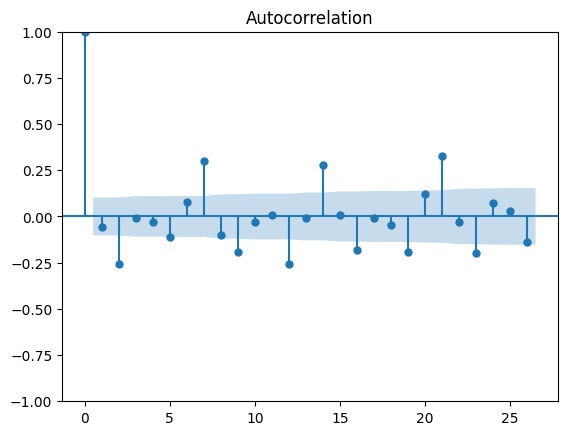

In [37]:

plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t)

In [42]:
from statsmodels.tsa.arima.model import ARIMA

# Khởi tạo và phù hợp với mô hình ARIMA
model_arima = ARIMA(r_t, order=(2, 0, 2))
model_fit = model_arima.fit()

# In ra tóm tắt của mô hình
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 563.727
Date:                Tue, 07 May 2024   AIC                          -1115.453
Time:                        10:57:35   BIC                          -1092.054
Sample:                             0   HQIC                         -1106.154
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.211      0.833      -0.002       0.001
ar.L1         -0.0635      0.066     -0.956      0.339      -0.194       0.067
ar.L2          0.5935      0.061      9.713      0.0

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
